In [1]:
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision
from torchvision.models import list_models, get_model
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import copy
import os
import zipfile
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
PATH = ''
DATA_SUBSET = None
BATCH_SIZE = 128
DATA_SUBSET = 7 # comment if not needed

In [5]:
all_models = list_models()
classification_models = list_models(module=torchvision.models)

In [6]:
# classification_models

In [7]:
# model_names = ['resnet18']
# model_names = ['mobilenet_v3_small', 'resnet18']
model_names = ['mobilenet_v3_large', 'mobilenet_v3_small', 'resnet50', 'resnet18', 'vgg11', 'vgg19', 'convnext_small']
# model_names = ['vgg19', 'convnext_small']

### COLAB STUFF

In [8]:
# PATH = '/content/drive/MyDrive/Master/Computational_social_choice/final_project/'

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
#!cp -av /content/drive/MyDrive/Master/Computational_social_choice/final_project/data /content/data

In [11]:
# img_zip_path = '/content/data/celeba/img_align_celeba.zip'
# zip_ref = zipfile.ZipFile(img_zip_path, 'r')
# zip_ref.extractall('/content/data/celeba/')
# zip_ref.close()

### Load Data

In [8]:
data_path = 'data'
# training_data = datasets.CelebA(root=data_path, split='train', target_type='attr', download=False, transform=ToTensor())
# validation_data = datasets.CelebA(root=data_path, split='valid', target_type='attr', download=False, transform=ToTensor())
test_data = datasets.CelebA(root=data_path, split='test', target_type='attr', download=False, transform=ToTensor())

In [9]:
try:
    print(len(training_data)//DATA_SUBSET)
    idxs_train = random.sample(list(range(0, len(training_data))), len(training_data)//DATA_SUBSET)
    idx_val = random.sample(list(range(0, len(validation_data))), len(validation_data)//DATA_SUBSET)
    idx_test = random.sample(list(range(0, len(test_data))), len(test_data)//DATA_SUBSET)
    training_data_sub = torch.utils.data.Subset(training_data, idxs_train)
    validation_data_sub = torch.utils.data.Subset(validation_data, idx_val)
    test_data_sub = torch.utils.data.Subset(test_data, idx_test)
except Exception as e:
    print(e)
    pass

name 'training_data' is not defined


In [26]:
labels = ['5_o_Clock_Shadow','Arched_Eyebrows','Attractive','Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Black_Hair',
'Blond_Hair', 'Blurry','Brown_Hair','Bushy_Eyebrows','Chubby','Double_Chin','Eyeglasses','Goatee','Gray_Hair','Heavy_Makeup',
'High_Cheekbones','Male','Mouth_Slightly_Open','Mustache','Narrow_Eyes','No_Beard','Oval_Face','Pale_Skin','Pointy_Nose',
'Receding_Hairline','Rosy_Cheeks','Sideburns','Smiling','Straight_Hair','Wavy_Hair','Wearing_Earrings','Wearing_Hat',
'Wearing_Lipstick','Wearing_Necklace','Wearing_Necktie','Young']
def plotImages(data, preds=None):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 1, 5
    maximum = len(preds) if preds is not None else np.inf
    for i in range(1, min(cols * rows, maximum) + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        if(preds != None):
            img = data[i-1]
            label = preds[i-1]
        else:
            img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)

        plt.title(', '.join([labels[idx] for idx, lab in enumerate(label) if lab == 1]))
        plt.axis("off")
        plt.imshow(img.squeeze().permute(1,2,0))
    plt.show()
plotImages(training_data)

NameError: name 'training_data' is not defined

In [18]:
training_data[0][1]

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [19]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

if(DATA_SUBSET is not None):
    print('using subset')
    train_dataloader = DataLoader(training_data_sub, batch_size=BATCH_SIZE, shuffle=True)
    validation_dataloader = DataLoader(validation_data_sub, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_data_sub, batch_size=BATCH_SIZE, shuffle=False)


NameError: name 'training_data' is not defined

In [9]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = []
    accuracies = []
    losses_val = []
    accuracies_val = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            epoch = 0
            running_loss = 0.0
            running_acc = 0.0
            running_corrects = []

            # Iterate over data.
            dataloader = None
            dataset_size = None
            if(phase == 'train'):
                dataloader = train_dataloader
                dataset_size = len(training_data)
            elif(phase == 'val'):
                dataloader = validation_dataloader
                dataset_size = len(validation_data)
            
            for i, (inputs, labels) in enumerate(tqdm(dataloader)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                batch_acc = torch.mean(torch.round(outputs).eq(labels).sum(axis=1)/labels.size(1))
                running_acc += batch_acc
                # running_corrects += torch.sum(outputs == labels.float().data)
                epoch += 1
            if(phase == 'train' and scheduler != None):
                scheduler.step()
            
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_acc / epoch 
            if(phase == 'train'):
                losses.append(epoch_loss)
                accuracies.append(epoch_acc)
            elif(phase == 'val'):
                losses_val.append(epoch_loss)
                accuracies_val.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    model.to('cpu')
    return model, losses, accuracies, losses_val, accuracies_val

In [10]:
def addNewFC(model, model_name, n_labels=40):
    for param in model.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    if('mobile' in model_name):
        num_ftrs = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, n_labels),
            nn.Sigmoid()
        )
    elif('vgg' in model_name):
        classifier_length = len(model.classifier)
        num_ftrs = model.classifier[classifier_length-1].out_features
        model.classifier.add_module(str(classifier_length), nn.ReLU(inplace=True))
        model.classifier.add_module(str(classifier_length+1), nn.Linear(num_ftrs, n_labels))
        model.classifier.add_module(str(classifier_length+2), nn.Sigmoid())
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif('convnext' in model_name):
        classifier_length = len(model.classifier)
        num_ftrs = model.classifier[classifier_length-1].in_features
        model.classifier[classifier_length-1] = nn.Linear(num_ftrs, n_labels)
        model.classifier.add_module(str(classifier_length), nn.Sigmoid())
        for param in model.classifier.parameters():
            param.requires_grad = True
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, n_labels),
            nn.Sigmoid()
        )
    # model = model.to(device)
    return model

In [11]:
models = [addNewFC(get_model(model_name, weights="DEFAULT"), model_name, 40) for model_name in model_names]
optimizers = [torch.optim.Adam(model.parameters()) for model in models]
schedulers = [None for optimizer in optimizers]
# schedulers = [lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8) for optimizer in optimizers]
# optimizers = [torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) for model in models]
# schedulers = [lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) for optimizer in optimizers]
criterion = nn.BCELoss()

In [17]:
for model, optimizer, scheduler, model_name in zip(models, optimizers, schedulers, model_names):
    print(model_name)
    num_epochs = 10
    model, losses, accuracies, losses_val, accuracies_val = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)
    model.eval()
    accuracy = 0.0
    running_loss = 0.0
    epochs = 0
    dataset_size = len(test_data_sub)
    for test_inputs, test_labels in test_dataloader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        outputs = model(test_inputs)
        loss = criterion(outputs, test_labels.float())
        running_loss += loss.item() * test_inputs.size(0)
        test_acc = torch.mean(torch.round(outputs).eq(test_labels).sum(axis=1)/test_labels.size(1))
        accuracy += test_acc
        epochs += 1
    epoch_loss = running_loss / dataset_size
    accuracy = accuracy / epochs
    print(epoch_loss)
    print(accuracy)

    PATH = '08_04_' + model_name + 'v3.pt'
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': {
            'train': losses,
            'val': losses_val
        },
        'accuracy_history': {
            'train': accuracies,
            'val': accuracies_val
        },
        'test_acc': accuracy,
        'test_loss': epoch_loss
        }, PATH)

vgg19
Epoch 0/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [08:41<00:00,  2.87s/it]


train Loss: 0.0509 Acc: 0.8446


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:00<00:00,  2.64s/it]


val Loss: 0.0437 Acc: 0.8662

Epoch 1/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:39<00:00,  1.21s/it]


train Loss: 0.0445 Acc: 0.8638


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:27<00:00,  1.18s/it]


val Loss: 0.0418 Acc: 0.8736

Epoch 2/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:43<00:00,  1.23s/it]


train Loss: 0.0425 Acc: 0.8699


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.11s/it]


val Loss: 0.0408 Acc: 0.8754

Epoch 3/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:39<00:00,  1.21s/it]


train Loss: 0.0409 Acc: 0.8746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.15s/it]


val Loss: 0.0404 Acc: 0.8758

Epoch 4/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:37<00:00,  1.19s/it]


train Loss: 0.0398 Acc: 0.8777


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]


val Loss: 0.0397 Acc: 0.8789

Epoch 5/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:41<00:00,  1.21s/it]


train Loss: 0.0389 Acc: 0.8800


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.09s/it]


val Loss: 0.0404 Acc: 0.8779

Epoch 6/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:49<00:00,  1.26s/it]


train Loss: 0.0379 Acc: 0.8831


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.12s/it]


val Loss: 0.0398 Acc: 0.8802

Epoch 7/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:41<00:00,  1.22s/it]


train Loss: 0.0372 Acc: 0.8850


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]


val Loss: 0.0402 Acc: 0.8777

Epoch 8/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [03:41<00:00,  1.22s/it]


train Loss: 0.0366 Acc: 0.8867


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:25<00:00,  1.10s/it]


val Loss: 0.0392 Acc: 0.8790

Epoch 9/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [04:07<00:00,  1.36s/it]


train Loss: 0.0361 Acc: 0.8885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:27<00:00,  1.20s/it]


val Loss: 0.0394 Acc: 0.8802

Training complete in 47m 18s
Best val Acc: 0.880246
0.2821569546968299
tensor(0.8760, device='cuda:0')
convnext_small
Epoch 0/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [07:00<00:00,  2.31s/it]


train Loss: 0.0507 Acc: 0.8475


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:32<00:00,  1.40s/it]


val Loss: 0.0444 Acc: 0.8643

Epoch 1/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:04<00:00,  1.67s/it]


train Loss: 0.0437 Acc: 0.8664


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.69s/it]


val Loss: 0.0417 Acc: 0.8716

Epoch 2/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:32<00:00,  1.83s/it]


train Loss: 0.0421 Acc: 0.8707


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:38<00:00,  1.68s/it]


val Loss: 0.0408 Acc: 0.8744

Epoch 3/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:12<00:00,  1.72s/it]


train Loss: 0.0412 Acc: 0.8730


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:37<00:00,  1.64s/it]


val Loss: 0.0400 Acc: 0.8761

Epoch 4/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:11<00:00,  1.71s/it]


train Loss: 0.0406 Acc: 0.8748


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:37<00:00,  1.65s/it]


val Loss: 0.0400 Acc: 0.8757

Epoch 5/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:10<00:00,  1.71s/it]


train Loss: 0.0404 Acc: 0.8754


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:37<00:00,  1.64s/it]


val Loss: 0.0394 Acc: 0.8782

Epoch 6/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:12<00:00,  1.72s/it]


train Loss: 0.0402 Acc: 0.8760


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:37<00:00,  1.65s/it]


val Loss: 0.0390 Acc: 0.8792

Epoch 7/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:10<00:00,  1.71s/it]


train Loss: 0.0398 Acc: 0.8768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:37<00:00,  1.65s/it]


val Loss: 0.0390 Acc: 0.8790

Epoch 8/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:03<00:00,  1.67s/it]


train Loss: 0.0397 Acc: 0.8774


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:40<00:00,  1.76s/it]


val Loss: 0.0388 Acc: 0.8798

Epoch 9/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [05:24<00:00,  1.78s/it]


train Loss: 0.0396 Acc: 0.8780


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:35<00:00,  1.54s/it]


val Loss: 0.0389 Acc: 0.8799

Training complete in 60m 20s
Best val Acc: 0.879924
0.27555453386360285
tensor(0.8775, device='cuda:0')


In [12]:
# Load Models
for model, optimizer, scheduler, model_name in zip(models, optimizers, schedulers, model_names):
    checkpoint = torch.load('08_04_'+model_name+'v3.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch = checkpoint['epoch']
    # loss = checkpoint['loss']
    model.eval()

In [22]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
len(preds2)

NameError: name 'preds2' is not defined

In [27]:
# preds2 = [pred for pred in preds]
# losses2 = [pred for pred in losses]
# accuracies2 = [pred for pred in accuracies]

In [19]:
preds = []
losses = []
accuracies = []
for model, optimizer, scheduler, model_name in zip(models[5:], optimizers[5:], schedulers[5:], model_names[5:]):
    model.to(device)
    print(model_name)
    model.eval()
    accuracy = 0.0
    running_loss = 0.0
    epochs = 0
    dataset_size = len(test_data)
    preds_model = []
    for i, (test_inputs, test_labels) in enumerate(tqdm(test_dataloader)):
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        outputs = model(test_inputs)
        loss = criterion(outputs, test_labels.float())
        running_loss += loss.item() * test_inputs.size(0)
        test_acc = torch.mean(torch.round(outputs).eq(test_labels).sum(axis=1)/test_labels.size(1))
        accuracy += test_acc
        preds_model.append(outputs.to('cpu'))
        # print(torch.round(outputs))
        # print(test_labels)
        # print(test_acc)
        epochs += 1
    epoch_loss = running_loss / dataset_size
    accuracy = accuracy / epochs
    preds.append(preds_model)
    losses.append(epoch_loss)
    accuracies.append(accuracy)
    model.to('cpu')
    del model
    torch.cuda.empty_cache()
    print(epoch_loss)
    print(accuracy)

vgg19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [04:12<00:00,  1.62s/it]


0.2847009779139495
tensor(0.8749, device='cuda:0')
convnext_small


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [03:32<00:00,  1.36s/it]

0.2773895161673344
tensor(0.8772, device='cuda:0')


In [20]:
len(preds)

2

In [4]:
import pickle
# with open('preds.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([preds, losses, accuracies, model_names], f)

In [5]:
# with open('preds.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
#     preds, losses, accuracies, model_names = pickle.load(f)

In [30]:
preds

[[tensor([[0.0067, 0.1342, 0.3268,  ..., 0.0509, 0.0155, 0.2474],
          [0.1075, 0.1450, 0.3243,  ..., 0.1075, 0.0237, 0.7835],
          [0.0038, 0.2789, 0.8432,  ..., 0.2448, 0.0017, 0.8986],
          ...,
          [0.0096, 0.2553, 0.7268,  ..., 0.3375, 0.0023, 0.9331],
          [0.0525, 0.0350, 0.0966,  ..., 0.0199, 0.0151, 0.8742],
          [0.0221, 0.1689, 0.9247,  ..., 0.1560, 0.0025, 0.9841]],
         requires_grad=True),
  tensor([[0.0252, 0.1065, 0.7291,  ..., 0.1014, 0.0071, 0.6675],
          [0.0324, 0.0804, 0.0546,  ..., 0.1063, 0.0263, 0.6138],
          [0.2323, 0.0925, 0.5812,  ..., 0.0289, 0.0096, 0.8410],
          ...,
          [0.0679, 0.0539, 0.5143,  ..., 0.1163, 0.0102, 0.9097],
          [0.1897, 0.0264, 0.0758,  ..., 0.0397, 0.0273, 0.4733],
          [0.0999, 0.1065, 0.1552,  ..., 0.0110, 0.4226, 0.5270]],
         requires_grad=True),
  tensor([[5.2868e-03, 9.9176e-02, 8.3873e-01,  ..., 1.7963e-01, 1.9781e-03,
           9.7674e-01],
          [7.14

In [31]:
new_preds = []
for model in preds:
    new_batch = []
    for batch in model:
        new_batch.append(batch.detach().numpy())
    new_preds.append(new_batch)
new_accuracies = [float(acc.cpu().numpy()) for acc in accuracies]

In [32]:
# with open('preds_formatted.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([new_preds, losses, new_accuracies, model_names], f)

In [38]:
# with open('preds_last2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
#     preds2, losses2, accuracies2, model_names2 = pickle.load(f)

In [40]:
# model_names = model_names + model_names2
# losses = losses + losses2
# accuracies = accuracies + accuracies2
# preds = preds + preds2

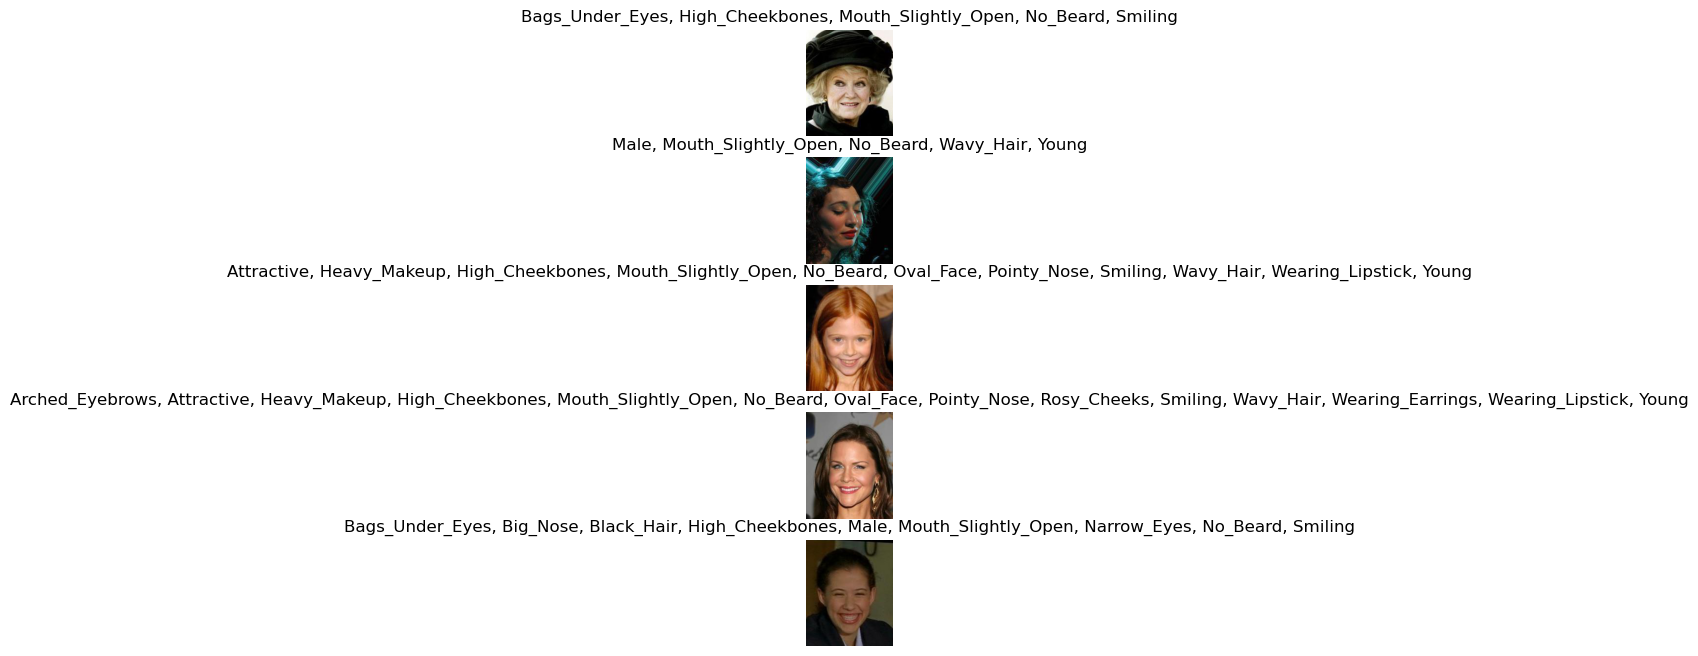

In [33]:
test_model = models[0]
test_model.to(device)
data = next(iter(test_dataloader))
preds = torch.round(test_model(data[0].to(device))).int()
plotImages(data[0], preds)

In [1]:
plotImages(data[0], data[1])

NameError: name 'plotImages' is not defined

In [34]:
data[0].size()

torch.Size([128, 3, 218, 178])

In [35]:
from PIL import Image
import torchvision.transforms as transforms


image = Image.open('002.jpg')

transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor()
])

img_tensor = transform(image)


In [36]:
torch.unsqueeze(img_tensor, 0).size()

torch.Size([1, 3, 218, 178])

In [37]:
preds = torch.round(test_model(torch.unsqueeze(img_tensor, 0).to(device))).int()
preds

tensor([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.int32)

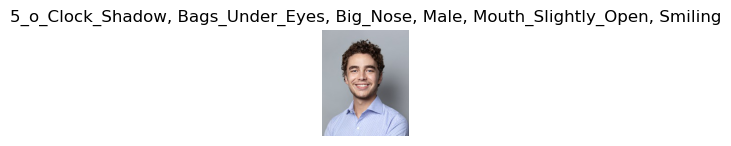

In [38]:
plotImages([img_tensor], preds)

In [48]:
len(preds[0][0])

128